## Data acquisition and importing


In [1]:
#Importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor


# Read all the CSV files into datasets
df_job_postings = pd.read_csv("job_postings.csv")
df_company_industries = pd.read_csv("company_industries.csv")
df_companies = pd.read_csv("companies.csv")
df_company_specialities = pd.read_csv("company_specialities.csv")
df_benefits = pd.read_csv("benefits.csv") #Job benefits such as Medical insurance and Dental insurance, do we want to use this??
df_employee_counts = pd.read_csv("employee_counts.csv") #Linkedin information employee_count and follower_count, do we want to use this??
df_industries = pd.read_csv("industries.csv")  #Job_postings file included the industries already
df_job_industries = pd.read_csv("job_industries.csv") #Job_postings file included the industries already(This links with previous file)
df_job_skills = pd.read_csv("job_skills.csv")
df_skills = pd.read_csv("skills.csv")
df_salaries = pd.read_csv("salaries.csv")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 400)

## DataFrame construction

In [2]:
#Pick out relavant data for our research and make a dataframe where all the infromation is linked to job_id

#Columns of interest from the job_postings csv file
df_job_postings_columns = ['job_id', 'company_id', 'title', 'description']
df_main = df_job_postings[df_job_postings_columns]
df_main.to_csv('main_dataframe.csv', index=False)
df_main = df_main.rename(columns={'title': 'job_title'})

#Columns of interest from company_industries file
df_main = pd.merge(df_main, df_company_industries[['company_id', 'industry']], on='company_id', how='left')

#Columns of interest from companies file
df_main = pd.merge(df_main, df_companies[['company_id', 'company_size','country']], on='company_id', how='left')

#Columns of interest from company_specialities file
df_main = pd.merge(df_main, df_company_specialities[['company_id', 'speciality']], on='company_id', how='left')
df_main = df_main.rename(columns={'speciality': 'company_speciality'})

#Columns of interest from job_skills file, changing the acronym to a word using the definitons of acronyms from skills file
df_main = pd.merge(df_main, df_job_skills[['job_id', 'skill_abr']], on='job_id', how='left')
df_main = pd.merge(df_main, df_skills, left_on='skill_abr', right_on='skill_abr', how='left')
df_main.drop(columns='skill_abr', inplace=True)
df_main = df_main.rename(columns={'skill_name': 'work_specialization'})

#Columns of interest from salaries file
df_main = pd.merge(df_main, df_salaries[['job_id', 'max_salary','med_salary','min_salary','pay_period','currency','compensation_type']], on='job_id', how='left')

#Changing the column order to better visualize the data
desired_column_order = ['job_id', 'company_id', 'country','industry', 'company_speciality', 'company_size', 'job_title', 'work_specialization', 'description', 'max_salary','med_salary','min_salary','pay_period','currency','compensation_type']
df_main = df_main[desired_column_order]
df_main.drop_duplicates(subset=['job_id'], keep='first', inplace=True, ignore_index=True)

## Data transformation and filtering for wage analysis 

In [3]:
# Creating a duplicate DataFrame for wage comparisons
df_main_wages = df_main.copy()  # Making a copy to retain the original data

# Dropping rows with NaN values in the 'compensation_type' column
df_main_wages.dropna(subset=['compensation_type'], inplace=True)

# Converting all salaries to hourly wages assuming 40 working hours per week, 172 hours in a month, and 2080 hours in a year
# Additionally, adjusting some listings to ensure comparability between max, min, and median salaries
# The equation used: (min_salary + max_salary) / 2 for listings without 'med_salary'
# Removing a row with a 'pay_period' value of 'ONCE'
df_main_wages.drop(df_main_wages[df_main_wages['pay_period'] == 'ONCE'].index, inplace=True)

hourly_conversion = {
    'HOURLY': 1,
    'YEARLY': 2080,
    'MONTHLY': 172,
    'WEEKLY': 40
}

def convert_to_hourly(row):
    conversion = row["pay_period"]

    if pd.notnull(row['med_salary']):
        hourly_rate = row['med_salary'] / hourly_conversion[conversion]
        row['average_hourly_rate'] = round(hourly_rate, 2)
    else:
        hourly_rate = (row['min_salary'] + row['max_salary']) / 2 / hourly_conversion[conversion]
        row['average_hourly_rate'] = round(hourly_rate, 2)

    return row

# Applying the function to create a new 'average_hourly_rate' column
df_main_wages['average_hourly_rate'] = df_main_wages.apply(convert_to_hourly, axis=1)['average_hourly_rate']

# Dropping unnecessary columns ('max_salary', 'min_salary', 'med_salary', 'compensation_type') from the new DataFrame
columns_to_drop = ["max_salary", "min_salary", "med_salary", "compensation_type","currency",'description']
df_main_wages.drop(columns=columns_to_drop, inplace=True)

# Filtering outlier rows in df_main_wages with an average hourly rate above $400
outlier_row = df_main_wages[df_main_wages['average_hourly_rate'] > 400]

# Extracting unique job IDs from the outlier rows
outlier_job_ids = outlier_row['job_id'].unique()

# Filtering main DataFrame 'df_main' based on the outlier job IDs
combined_filtered = df_main[df_main['job_id'].isin(outlier_job_ids)]

# Merging and sorting df_main by 'average_hourly_rate' from df_main_wages for manual inspection
combined_filtered_sorted = combined_filtered.merge(df_main_wages[['job_id', 'average_hourly_rate']], on='job_id')
combined_filtered_sorted = combined_filtered_sorted.sort_values(by='average_hourly_rate', ascending=True)  # Manual inspection performed

# After manual inspection, identified illogical values; filtered outliers above $505 hourly rate
high_hourly_rate = df_main_wages[df_main_wages['average_hourly_rate'] > 505]

# Removed rows with an average hourly rate over $505 from the DataFrame
df_main_wages.drop(high_hourly_rate.index, inplace=True)

##  CatBoost Regressor training and evaluation with R-squared Scores


In [4]:
%%time

# Fill missing values in categorical columns
categorical_cols = ['country', 'industry', 'company_speciality', 'job_title', 'work_specialization', 'pay_period']
for col in categorical_cols:
    df_main_wages[col].fillna('Unknown', inplace=True)

# Drop 'job_id' and 'company_id' columns
X = df_main_wages.drop(['average_hourly_rate', 'job_id', 'company_id'], axis=1)
y = df_main_wages['average_hourly_rate']

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Initialize CatBoostRegressor model
model = CatBoostRegressor(iterations=2000, depth=5, verbose=0, learning_rate=0.01, loss_function='RMSE')

# Train the model
model.fit(X_train, y_train, cat_features=categorical_cols)

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate R-squared
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Display R-squared scores
print(f"CatBoost R-squared for train set: {r2_train:.3f}")
print(f"CatBoost R-squared for test set: {r2_test:.3f}")

# Feature importance calculation
feature_importance = model.get_feature_importance(data=Pool(X_train, label=y_train, cat_features=categorical_cols), 
                                                 type="LossFunctionChange")

# Creating a results DataFrame
results_df = pd.DataFrame(columns=['Model','Train_R2','Test_R2'])
new_row_catboost = pd.DataFrame({'Model': ['CatBoost Regressor'], 'Train_R2': [r2_train], 'Test_R2': [r2_test]})
results_df = pd.concat([results_df, new_row_catboost], ignore_index=True)

# Displaying feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

CatBoost R-squared for train set: 0.562
CatBoost R-squared for test set: 0.375
CPU times: total: 1min 9s
Wall time: 23.5 s


,Feature,Importance
4,job_title,2.401741
6,pay_period,0.303140
2,company_speciality,0.268017
1,industry,0.196224
5,work_specialization,0.140448
0,country,0.113442
3,company_size,0.034204


## Categorical Data Processing and One-Hot Encoding

In [5]:
categorical_cols = ['country', 'industry', 'company_speciality', 'job_title', 'work_specialization',"pay_period"]
# One-hot encode categorical columns
df_encoded = pd.get_dummies(df_main_wages, columns=categorical_cols, drop_first=True)
#Removeing rows containing NaN 
df_encoded.dropna(inplace=True)

## XGBoost model training and evaluation with R-squared Scores

In [6]:
%%time

# Splitting the encoded DataFrame into features and target
X = df_encoded.drop(['average_hourly_rate', 'job_id', 'company_id'], axis=1)
y = df_encoded['average_hourly_rate']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=420)

# Replace problematic characters in column names
X_train.columns = [col.replace('[', '_').replace(']', '_').replace('<', '_') for col in X_train.columns]
X_test.columns = [col.replace('[', '_').replace(']', '_').replace('<', '_') for col in X_test.columns]

# Initialize XGBoost Regressor
xgb_model = XGBRegressor()

# Train the XGBoost model
xgb_model.fit(X_train, y_train)

# Make predictions on both train and test sets
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

# Calculate R-squared scores
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Display R-squared scores
print(f"XGBoost R-squared for train set: {r2_train:.3f}")
print(f"XGBoost R-squared for test set: {r2_test:.3f}")

# Add results to the DataFrame
new_row = pd.DataFrame({'Model': ['XGBoost'], 'Train_R2': [r2_train], 'Test_R2': [r2_test]})
results_df = pd.concat([results_df, new_row], ignore_index=True)

XGBoost R-squared for train set: 0.646
XGBoost R-squared for test set: 0.378
CPU times: total: 1min 31s
Wall time: 22.5 s


## Random Forest Regressor model training and evaluation with R-squared Scores

In [7]:
%%time

# Initialize Random Forest Regressor
rf_model = RandomForestRegressor()

# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Make predictions on both train and test sets
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calculate R-squared scores
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Display R-squared scores
print(f"Random Forest R-squared for train set: {r2_train:.3f}")
print(f"Random Forest R-squared for test set: {r2_test:.3f}")

# Add results to the DataFrame
new_row_rf = pd.DataFrame({'Model': ['Random Forest Regressor'], 'Train_R2': [r2_train], 'Test_R2': [r2_test]})
results_df = pd.concat([results_df, new_row_rf], ignore_index=True)

Random Forest R-squared for train set: 0.910
Random Forest R-squared for test set: 0.376
CPU times: total: 7min 22s
Wall time: 7min 22s


## Decision Tree Regressor model training and evaluation with R-squared Scores

In [8]:
%%time

# Initialize Decision Tree Regressor
dt_model = DecisionTreeRegressor()

# Train the Decision Tree model
dt_model.fit(X_train, y_train)

# Make predictions on both train and test sets
y_train_pred_dt = dt_model.predict(X_train)
y_test_pred_dt = dt_model.predict(X_test)

# Calculate R-squared scores
r2_train_dt = r2_score(y_train, y_train_pred_dt)
r2_test_dt = r2_score(y_test, y_test_pred_dt)

# Display R-squared scores
print(f"Decision Tree R-squared for train set: {r2_train_dt:.3f}")
print(f"Decision Tree R-squared for test set: {r2_test_dt:.3f}")

# Add results to the DataFrame
new_row_dt = pd.DataFrame({'Model': ['Decision Tree Regressor'], 'Train_R2': [r2_train_dt], 'Test_R2': [r2_test_dt]})
results_df = pd.concat([results_df, new_row_dt], ignore_index=True)

Decision Tree R-squared for train set: 0.997
Decision Tree R-squared for test set: 0.258
CPU times: total: 9.81 s
Wall time: 9.81 s


## KNeighbors Regressor training and evaluation with R-squared Scores





In [9]:
%%time

# Initialize KNN Regressor
knn_model = KNeighborsRegressor()

# Train the KNN model
knn_model.fit(X_train, y_train)

# Make predictions on both train and test sets
y_train_pred_knn = knn_model.predict(X_train)
y_test_pred_knn = knn_model.predict(X_test)

# Calculate R-squared scores
r2_train_knn = r2_score(y_train, y_train_pred_knn)
r2_test_knn = r2_score(y_test, y_test_pred_knn)

# Display R-squared scores
print(f"KNN R-squared for train set: {r2_train_knn:.3f}")
print(f"KNN R-squared for test set: {r2_test_knn:.3f}")

# Add results to the DataFrame
new_row_knn = pd.DataFrame({'Model': ['KNN Regressor'], 'Train_R2': [r2_train_knn], 'Test_R2': [r2_test_knn]})
results_df = pd.concat([results_df, new_row_knn], ignore_index=True)
results_df

KNN R-squared for train set: 0.563
KNN R-squared for test set: 0.266
CPU times: total: 1min 48s
Wall time: 31.6 s


,Model,Train_R2,Test_R2
0,CatBoost Regressor,0.561585,0.375339
1,XGBoost,0.646474,0.378477
2,Random Forest Regressor,0.910387,0.375738
3,Decision Tree Regressor,0.996803,0.257572
4,KNN Regressor,0.563213,0.265735


## Model Performance and Limitations in Wage Prediction

The initial approach aimed to predict wages for job listings lacking specified wage information using CatBoost. The decision to leverage CatBoost was to avoid one-hot encoding the data and incorporate job descriptions in the training process. However, this approach yielded unsatisfactory results as the model exhibited substantial overfitting on the training data.

In response, various alternative models—such as XGBoost, Random Forest Regressor, Decision Tree Regressor, and KNN Regressor—were explored. Despite the model variations, all showcased analogous outcomes by overfitting on the training data.

The predictive parameters encompassed 'country', 'industry', 'company_speciality', 'company_size', 'job_title', 'work_specialization', and 'pay_period', predicting the previously calculated 'average_hourly_rate'.

While attempting diverse models, the challenge of overfitting persisted across each model variation. Despite the differences in algorithmic approaches, none effectively mitigated overfitting or substantially improved predictive accuracy.

This outcome suggests that despite hyperparameter tuning and attempts with various models, the complexity inherent in the dataset remains a challenge. The selected features and model configurations might not fully encapsulate the subtleties required to generalize well to unseen data.

## Visualization: Top 30 highest payed industreis

C:\Users\joose\AppData\Local\Temp\ipykernel_996\3425656102.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='industry', y='average_hourly_rate', data=top_30_df, ci=None, order=top_30_industries)


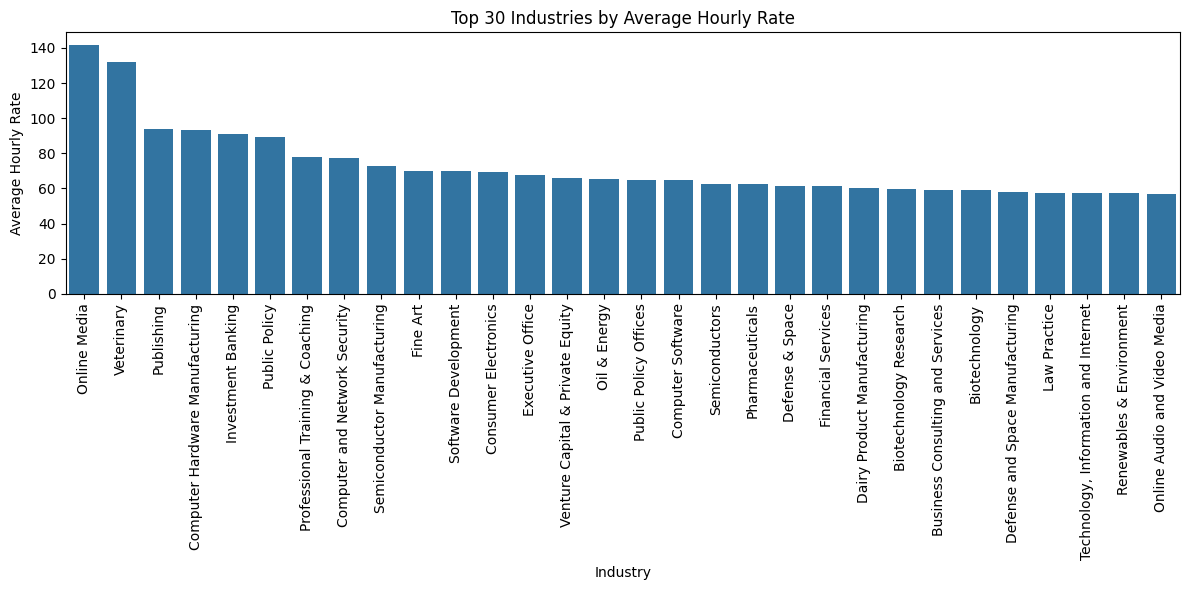

In [10]:
# Calculate average hourly rate for each industry
industry_avg_rate = df_main_wages.groupby('industry')['average_hourly_rate'].mean().sort_values(ascending=False)

# Select top 30 industries
top_30_industries = industry_avg_rate.head(30).index.tolist()

# Filter dataframe for the top 30 industries
top_30_df = df_main_wages[df_main_wages['industry'].isin(top_30_industries)]

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='industry', y='average_hourly_rate', data=top_30_df, ci=None, order=top_30_industries)
plt.xticks(rotation=90)
plt.xlabel('Industry')
plt.ylabel('Average Hourly Rate')
plt.title('Top 30 Industries by Average Hourly Rate')
plt.tight_layout()
plt.show()


## Visualization: Frequency of Work Specializations in Job Postings

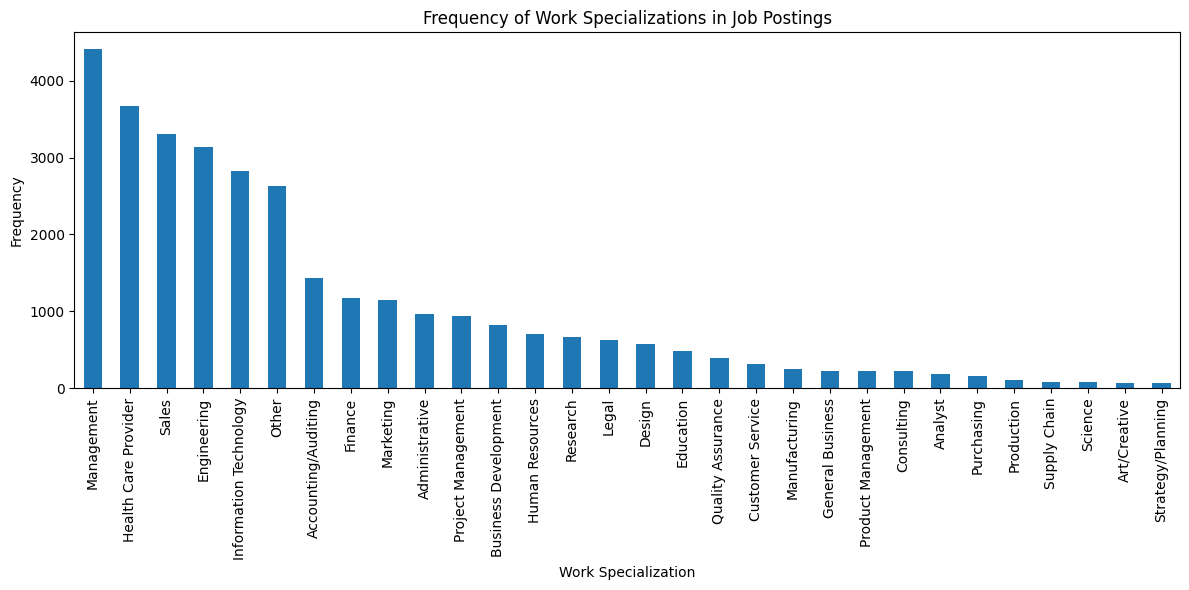

In [11]:
# Grouping by 'work_specialization' and getting the count for each specialization
work_specialization_counts = df_main['work_specialization'].value_counts()

# Taking top 30 specializations based on count
top_30_specializations = work_specialization_counts.head(30)

# Plotting the bar chart
plt.figure(figsize=(12, 6))
top_30_specializations.plot(kind='bar')
plt.xlabel('Work Specialization')
plt.ylabel('Frequency')
plt.title('Frequency of Work Specializations in Job Postings')
plt.xticks(rotation=90)  # Rotating x-axis labels for better readability
plt.tight_layout()
plt.show()